In [1]:
import os
import sys

seed = 0
os.environ['PYTHONHASSEED'] = str(seed)

In [2]:
import numpy as np
import pandas as pd
import time
import random

from tensorflow.random import set_seed

from sklearn.model_selection import train_test_split

from keras.models import load_model

In [3]:
# Add modules path
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [14]:
from src.data_reader import DataReader
from src.dataset_exploration import unit_cycle_info
from src.metrics import compute_evaluation_metrics
from src.model_evaluation import evaluate_mlp, evaluate_mlp_multiple_splits
from src.plotting import plot_loss_curves
from src.save_object import load_object
from src.training import train_evaluate_mlp, MLPConfigParams

In [5]:
# Set seed
random.seed(seed)
np.random.seed(seed)
set_seed(seed)

In [6]:
# Set input and output paths
filename = '../data/N-CMAPSS_DS02-006.h5'
output_path = '../results/experiment_set_17'

if not os.path.exists(output_path):
    os.makedirs(output_path)

In [7]:
data_reader = DataReader()

start_time = time.process_time()  
data_reader.load_dataset(filename, load_train=True, load_test=True)
print("Operation time (sec): " , (time.process_time() - start_time))

if data_reader.train_set is not None:
    print("Train set shape: " + str(data_reader.train_set.shape))
    
if data_reader.test_set is not None:   
    print("Test set shape: " + str(data_reader.test_set.shape))

Operation time (sec):  4.765625
Train set shape: (5263447, 47)
Test set shape: (1253743, 47)


In [8]:
train_set = data_reader.train_set

In [9]:
y_train = train_set['RUL']
x_train = train_set.drop(['RUL'], axis=1)

In [10]:
selected_columns = data_reader.column_names.w_cols + data_reader.column_names.x_s_cols
selected_columns_with_unit = selected_columns + ['unit']
x_train = x_train[selected_columns_with_unit]

In [11]:
x_train = x_train.astype(np.float32)
y_train = y_train.astype(np.float32)

Saved object to file: ../results/experiment_set_17\results_None_0\split_0\scaler.pkl
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 128)               2432      
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               33024     
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 64)                16448     
_________________________________________________________________
dropout_2 (Dropout)          (None, 64)                0         
_____________________________________

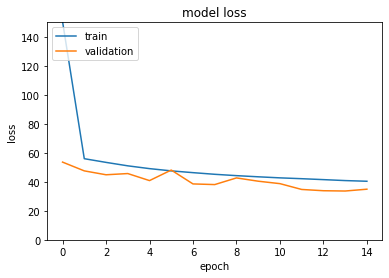

Saved object to file: ../results/experiment_set_17\results_None_0\split_0\history_0.pkl
Test set:
MSE: 33.55
RMSE: 5.79
CMAPSS score: 1.59

Saved object to file: ../results/experiment_set_17\results_None_0\split_1\scaler.pkl
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 128)               2432      
_________________________________________________________________
dropout_3 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 256)               33024     
_________________________________________________________________
dropout_4 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 64)                16448     
___________________________

In [ ]:
#########################################
# Effect of smoothing (experiment set 17)
#########################################
NUM_TRIALS = 3
EPOCHS = 15
BATCH_SIZE = 512

mlp_params = MLPConfigParams(layer_sizes=[128, 256, 64], activation='tanh', dropout=0.05)
alpha_vals = [0.01, 0.05, 0.1, 0.2, 0.3]
w_vals = [5, 10, 15, 20]

filter_params = [("None", 0)] + [("es", alpha) for alpha in alpha_vals] + [("ma", w) for w in w_vals]

results_file = os.path.join(output_path, "results_filtering.csv")
with open(results_file, "w") as file:
    file.write("filter_type,filter_param,mse,rmse,cmapss,mse(mean),mse(std),rmse(mean),rmse(std),cmapss(mean),cmapss(std)\n")


for params in filter_params:
    filter_type, filter_param = params
    
    results_folder = f"results_{filter_type}_{filter_param}"
    results_path = os.path.join(output_path, results_folder)
    if not os.path.exists(results_path):
        os.makedirs(results_path)
    
    # Filtering
    if filter_type == "None":
        x_train_filtered = x_train[selected_columns].astype(np.float32)
    else:
        x_train_filtered = signal_smoothing(x_train, selected_columns, filter_type, filter_param)
        x_train_filtered = x_train_filtered[selected_columns].astype(np.float32)
    
    # Validation split
    x_train_filtered, x_holdout_filtered, y_train_filtered, y_holdout_filtered = train_test_split(
        x_train_filtered, 
        y_train, 
        test_size=0.3, 
        random_state=seed)
    
    mse_vals, rmse_vals, cmapss_vals = train_evaluate_mlp(
        x_train_filtered, y_train_filtered, 
        x_holdout_filtered, y_holdout_filtered,
        NUM_TRIALS, 
        mlp_params, 
        results_path, 
        EPOCHS, BATCH_SIZE,
        results_file=results_file)